In [19]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Optional
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.impute import  KNNImputer
from sklearn.linear_model import LinearRegression
import random
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from tqdm import tqdm
from typing import Tuple, Optional, List, Dict
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed = 2024
seed_everything(seed)

In [3]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

In [4]:
train_df = pd.read_csv('train.csv')

target_columns = [col for col in train_df.columns if 'PCIAT' in col or 'sii' in col]
feature_columns = [col for col in train_df.columns if col not in target_columns]

train_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
pciat_cols = [col for col in train_df.columns if col.startswith('PCIAT') 
              and col != 'PCIAT-Season' 
              and col != 'PCIAT-PCIAT_Total']

missing_counts = train_df[pciat_cols].isnull().sum(axis=1)

rows_to_impute = missing_counts <= 5
print(f"Number of rows with 5 or fewer missing PCIAT values: {rows_to_impute.sum()}")

pciat_data = train_df.loc[rows_to_impute, pciat_cols].copy()

imputer = KNNImputer(n_neighbors=5)

imputed_data = imputer.fit_transform(pciat_data)

train_df.loc[rows_to_impute, pciat_cols] = imputed_data

print(f"Successfully imputed PCIAT values for {rows_to_impute.sum()} rows")
print(f"Number of rows with no missing PCIAT values after imputation: {train_df[pciat_cols].isnull().sum(axis=1).eq(0).sum()}")

Number of rows with 5 or fewer missing PCIAT values: 2734
Successfully imputed PCIAT values for 2734 rows
Number of rows with no missing PCIAT values after imputation: 2734


In [6]:
pciat_cols = [col for col in train_df.columns if col.startswith('PCIAT') 
              and col != 'PCIAT-Season' 
              and col != 'PCIAT-PCIAT_Total']

train_df['PCIAT-recalc_total'] = train_df[pciat_cols].sum(axis=1, skipna=False)


In [7]:
train_df

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,PCIAT-recalc_total
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,55.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,28.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0,44.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,NaN,NaN,NaN,NaN,Fall,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Fall,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.30138,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,NaN,NaN,Winter,3.260,Winter,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,1

In [8]:
train_with_sii = train_df #[train_df['sii'].notna()][target_columns]

PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
recalc_total_score = train_with_sii[PCIAT_cols].sum(
    axis=1, skipna=True
)
(recalc_total_score == train_with_sii['PCIAT-recalc_total']).all()

def recalculate_sii(row):
    if pd.isna(row['PCIAT-recalc_total']):
        return np.nan
    max_possible = row['PCIAT-recalc_total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-recalc_total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-recalc_total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-recalc_total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-recalc_total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train_df['recalc_sii'] = train_df.apply(recalculate_sii, axis=1)
train_df = train_df.drop('sii', axis=1)

train_df = train_df.dropna(subset='recalc_sii')

In [10]:
season_columns = [col for col in train_df.columns if 'Season' in col]
train_df = train_df.drop(season_columns, axis=1)

train_df.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,PCIAT-recalc_total,recalc_sii
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,3.0,55.0,2.0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,2.340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,64.0,0.0,0.0,0.0
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,5.0,7.0,33.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.170,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,38.0,54.0,2.0,28.0,0.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,6.0,9.0,37.0,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,2.451,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,31.0,45.0,0.0,44.0,1.0
5,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,4.110,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,34.0,40.0,56.0,0.0,34.0,1.0


In [9]:
features_for_wh = ['Basic_Demos-Age', 'Basic_Demos-Sex']
target_wh = ['Physical-Weight', 'Physical-Height']

knn_imputer = KNNImputer(n_neighbors=5)
wh_imputed = knn_imputer.fit_transform(train_df[features_for_wh + target_wh])
wh_imputed_df = pd.DataFrame(wh_imputed[:, -2:], columns=target_wh)

train_df['Physical-Weight'] = np.where(train_df['Physical-Weight'].isna(), 
                                     wh_imputed_df['Physical-Weight'],
                                     train_df['Physical-Weight'])
train_df['Physical-Height'] = np.where(train_df['Physical-Height'].isna(),
                                     wh_imputed_df['Physical-Height'], 
                                     train_df['Physical-Height'])

train_df['Physical-BMI'] = train_df['Physical-Weight'] / ((train_df['Physical-Height'] / 100) ** 2)

waist_model = LinearRegression()
waist_features = ['Physical-BMI', 'Physical-Weight']

complete_rows = train_df[waist_features + ['Physical-Waist_Circumference']].dropna()
X_waist = complete_rows[waist_features]
y_waist = complete_rows['Physical-Waist_Circumference']

scaler = StandardScaler()
X_waist_scaled = scaler.fit_transform(X_waist)

waist_model.fit(X_waist_scaled, y_waist)
    
missing_waist = train_df['Physical-Waist_Circumference'].isna()
if missing_waist.any():
    X_predict = scaler.transform(train_df.loc[missing_waist, waist_features])
    train_df.loc[missing_waist, 'Physical-Waist_Circumference'] = waist_model.predict(X_predict)

In [12]:
wh_cols = [
    'Physical-BMI', 'Physical-Height',
    'Physical-Weight', 'Physical-Waist_Circumference'
]

lbs_to_kg = 0.453592
inches_to_cm = 2.54

train_df['Physical-Weight'] = train_df['Physical-Weight'] * lbs_to_kg
train_df['Physical-Height'] = train_df['Physical-Height'] * inches_to_cm
train_df['Physical-Waist_Circumference'] = train_df['Physical-Waist_Circumference'] * inches_to_cm

train_df['Physical-BMI'] = np.where(
    train_df['Physical-Weight'].notna() & train_df['Physical-Height'].notna(),
    train_df['Physical-Weight'] / ((train_df['Physical-Height'] / 100) ** 2),
    np.nan  # If either is NaN, set BMI to NaN
)

train_df.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,PCIAT-recalc_total,recalc_sii
0,00008ff9,5,0,51.0,16.878972,116.84,23.042474,58.827127,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,3.0,55.0,2.0
1,000fd460,9,0,NaN,14.036968,121.92,20.865232,55.880000,75.0,70.0,122.0,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,2.340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,64.0,0.0,0.0,0.0
2,00105258,10,1,71.0,16.650330,143.51,34.291555,62.555015,65.0,94.0,117.0,5.0,7.0,33.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.170,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,38.0,54.0,2.0,28.0,0.0
3,00115b9f,9,0,71.0,18.294143,142.24,37.013107,65.500358,60.0,97.0,117.0,6.0,9.0,37.0,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,2.451,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,31.0,45.0,0.0,44.0,1.0
5,001f3379,13,1,50.0,22.282139,151.13,50.893022,75.235483,60.0,73.0,102.0,NaN,NaN,NaN,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,4.110,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,34.0,40.0,56.0,0.0,34.0,1.0


In [10]:
bp_hr_cols = [
    'Physical-Diastolic_BP', 'Physical-Systolic_BP',
    'Physical-HeartRate'
]

train_df[bp_hr_cols] = train_df[bp_hr_cols].replace(0, np.nan)
train_df.loc[train_df['Physical-Systolic_BP'] <= train_df['Physical-Diastolic_BP'], bp_hr_cols] = np.nan

train_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,PCIAT-recalc_total,recalc_sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,240.075614,46.0,50.8,23.160286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,55.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,199.652778,48.0,46.0,22.000000,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,236.823557,56.5,75.6,24.627959,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,28.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,260.204082,56.0,81.6,25.787542,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,44.0,1.0
5,001f3379,Spring,13,1,Winter,50.0,Summer,316.926771,59.5,112.2,29.620269,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,34.0,1.0


In [11]:
paq_cols = [
    'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total'
]

train_df['PAQ_Total_Combined'] = np.where(
    train_df['PAQ_A-PAQ_A_Total'].notna() & train_df['PAQ_C-PAQ_C_Total'].notna(),  
    (train_df['PAQ_A-PAQ_A_Total'] + train_df['PAQ_C-PAQ_C_Total']) / 2,
    train_df['PAQ_A-PAQ_A_Total'].combine_first(train_df['PAQ_C-PAQ_C_Total'])
)

train_df = train_df.drop(paq_cols, axis=1)

train_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,PCIAT-recalc_total,recalc_sii,PAQ_Total_Combined
0,00008ff9,Fall,5,0,Winter,51.0,Fall,240.075614,46.0,50.8,23.160286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,55.0,2.0,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,199.652778,48.0,46.0,22.000000,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,Fall,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,0.0,2.340
2,00105258,Summer,10,1,Fall,71.0,Fall,236.823557,56.5,75.6,24.627959,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,28.0,0.0,2.170
3,00115b9f,Winter,9,0,Fall,71.0,Summer,260.204082,56.0,81.6,25.787542,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,Winter,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,44.0,1.0,2.451
5,001f3379,Spring,13,1,Winter,50.0,Summer,316.926771,59.5,112.2,29.620269,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,Spring,Summer,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,34.0,1.0,4.110


In [12]:
def extract_daily_features(day_data: pd.DataFrame) -> Optional[dict]:
    """Calculate features for a single day"""
    SAMPLING_RATE = 0.2  # Hz
    SAMPLES_PER_DAY = int(24 * 60 * 60 * SAMPLING_RATE)
    
    if len(day_data) < (SAMPLES_PER_DAY * 0.5):
        return None
        
    features = {}
    
    # ENMO features
    features['enmo_mean'] = day_data['enmo'].mean()
    features['enmo_std'] = day_data['enmo'].std()
    
    # Posture changes
    angle_changes = np.abs(day_data['anglez'].diff())
    features['posture_changes'] = sum(angle_changes > 15)
    
    # Ensure timestamp index
    if not isinstance(day_data.index, pd.DatetimeIndex):
        day_data.index = pd.to_datetime(day_data.index)
    
    # Convert nanoseconds to hours
    day_data['hours'] = day_data['time_of_day'] // (3600 * 1_000_000_000)
    
    # Define night and day masks
    night_mask = (day_data['hours'] >= 22) | (day_data['hours'] <= 5)
    day_mask = (day_data['hours'] >= 7) & (day_data['hours'] <= 20)
    
    # Validate light values
    day_data['light'] = pd.to_numeric(day_data['light'], errors='coerce')
    
    # Calculate night light exposure
    night_light = day_data.loc[night_mask, 'light']
    valid_night_light = night_light[~night_light.isna()]
    features['night_light_exposure'] = valid_night_light.mean() if len(valid_night_light) > 0 else 0.0
    
    # Calculate mean light for day time
    day_light = day_data.loc[day_mask, 'light']
    valid_day_light = day_light[~day_light.isna()]
    features['light_mean'] = valid_day_light.mean() if len(valid_day_light) > 0 else 0.0
    
    # Sedentary time
    sedentary_samples = sum(day_data['enmo'] < 0.02)
    features['sedentary_time_hours'] = sedentary_samples / (SAMPLING_RATE * 3600)
    
    return features

def process_single_day(data: pd.DataFrame, day_start_idx: int, samples_per_day: int) -> Optional[dict]:
    """Process a single day of data and extract features"""
    day_end_idx = min(day_start_idx + samples_per_day, len(data))
    day_data = data.iloc[day_start_idx:day_end_idx]
    
    min_samples = (4 * 60 * 60) // 5  # Minimum 4 hours of data
    if len(day_data) < min_samples:
        return None
        
    try:
        features = extract_daily_features(day_data)
        return features
    except Exception as e:
        print(f"Error processing day: {str(e)}")
        return None

def process_file(file_id: str, dirname: str) -> Tuple[Optional[List], str]:
    """Process a single file and extract weekly features"""
    try:
        file_path = os.path.join(dirname, file_id)
        data = pd.read_parquet(file_path)
        
        samples_per_day = 24 * 60 * 60 // 5
        total_days = len(data) // samples_per_day + (1 if len(data) % samples_per_day > 0 else 0)
        
        daily_features = []
        
        for day in range(total_days):
            day_features = process_single_day(data, day * samples_per_day, samples_per_day)
            if day_features is not None:
                daily_features.append(day_features)
        
        return daily_features, file_id.replace('id=', '')

    except Exception as e:
        print(f"Error processing file {file_id}: {str(e)}")
        return None, file_id.replace('id=', '')

def load_time_series(dirname: str) -> pd.DataFrame:
    """Load and process all time series data from a directory"""
    # Read unique IDs
    temp_df = pd.read_parquet(dirname, columns=['id'])
    ids = temp_df['id'].unique()
    del temp_df
    
    print(f"Processing {len(ids)} unique IDs from {dirname}")
    
    # Process files in parallel
    max_workers = max(1, multiprocessing.cpu_count() - 1)
    all_features = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for id_value in ids:
            futures.append(
                executor.submit(process_file, f"id={id_value}", dirname)
            )
        
        for future in tqdm(futures, desc="Processing files"):
            features, id_str = future.result()
            if features is not None and len(features) > 0:
                all_features.append((features, id_str))
    
    if not all_features:
        raise ValueError("No valid features extracted")
    
    # Calculate number of days from first record
    num_days = 7  # We want 7 days of features
    
    # Create feature names
    base_features = ['enmo_mean', 'enmo_std', 'posture_changes', 
                    'night_light_exposure', 'light_mean', 'sedentary_time_hours']
    feature_names = []
    for day in range(num_days):
        for feat in base_features:
            feature_names.append(f"{feat}_day{day+1}")
    
    # Flatten and prepare results
    results = []
    for features, id_str in all_features:
        flat_features = []
        for day_features in features[:num_days]:  # Ensure consistent length
            for feat in base_features:
                flat_features.append(day_features.get(feat, 0.0))
        results.append((flat_features, id_str))
    
    # Create DataFrame
    features, indexes = zip(*results)
    df = pd.DataFrame(features, columns=feature_names)
    df['id'] = indexes
    
    return df

In [13]:
def main():
    train_ts = load_time_series("series_train.parquet")

    train_ts = train_ts.reset_index()
    train_ts = train_ts.rename(columns={'participant_id': 'id'})

    print("Merging datasets...")
    final_df = train_df.merge(train_ts, on='id', how='left')
    
    print(f"Final dataset shape: {final_df.shape}")
    return final_df

df = main()

Processing 996 unique IDs from series_train.parquet


Processing files: 100%|██████████| 996/996 [02:52<00:00,  5.76it/s]

Merging datasets...
Final dataset shape: (2731, 125)


In [14]:
df = df.drop('index', axis=1)

In [32]:
df[df['enmo_mean_day1'].notna()].head(20)

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,PCIAT-recalc_total,recalc_sii,PAQ_Total_Combined,enmo_mean_day1,enmo_std_day1,posture_changes_day1,night_light_exposure_day1,light_mean_day1,sedentary_time_hours_day1,enmo_mean_day2,enmo_std_day2,posture_changes_day2,night_light_exposure_day2,light_mean_day2,sedentary_time_hours_day2,enmo_mean_day3,enmo_std_day3,posture_changes_day3,night_light_exposure_day3,light_mean_day3,sedentary_time_hours_day3,enmo_mean_day4,enmo_std_day4,posture_changes_day4,night_light_exposure_day4,light_mean_day4,sedentary_time_hours_day4,enmo_mean_day5,enmo_std_day5,posture_changes_day5,night_light_exposure_day5,light_mean_day5,sedentary_time_hours_day5,enmo_mean_day6,enmo_std_day6,posture_changes_day6,night_light_exposure_day6,light_mean_day6,sedentary_time_hours_day6,enmo_mean_day7,enmo_std_day7,posture_changes_day7,night_light_exposure_day7,light_mean_day7,sedentary_time_hours_day7
3,00115b9f,Winter,9,0,Fall,71.0,Summer,260.204082,56.00,81.60,25.787542,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.841910,18.2943,1131.430,1923.44,15.5925,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,Winter,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,44.0,1.0,2.451,0.064901,0.147459,4715.0,35.541412,57.821499,11.276389,0.039977,0.073504,2768.0,33.676632,51.282013,9.233333,0.027482,0.035857,376.0,8.759263,7.939154,6.479167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001f3379,Spring,13,1,Winter,50.0,Summer,316.926771,59.50,112.20,29.620269,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.330360,30.1865,1330.970,1996.45,30.2124,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,Spring,Summer,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,34.0,1.0,4.110,0.020178,0.045156,1937.0,2.175640,82.200478,17.759722,0.012055,0.030498,1353.0,3.227993,32.292156,20.854167,0.018373,0.043812,1557.0,5.904484,109.895477,19.465278,0.019894,0.035038,1410.0,7.825445,69.284111,15.854167,0.020195,0.047971,1332.0,1.363201,31.474249,16.155556,0.007151,0.035283,790.0,10.679280,9.344335,22.719444,0.020016,0.058496,2138.0,1.812743,21.978870,19.490278
11,00f332d1,Winter,14,0,Spring,68.0,Spring,244.219571,66.50,108.00,26.933039,60.0,71.0,129.0,NaN,NaN,NaN,NaN,Spring,16.0,0.0,18.4,1.0,20.9,2.0,22.0,1.0,3.5,0.0,5.5,0.0,13.0,1.0,Spring,4.0,5.930560,17.1705,1414.240,2969.90,27.2818,92.8980,14.7695,2.40101,15.10200,2.0,41.4004,24.21580,86.9674,42.1074,68.6822,NaN,Winter,Spring,4.0,4.0,5.0,1.0,

In [23]:
LGBM_Params = {
        'objective': 'poisson', 
        'n_estimators': 300, 
        'max_depth': 4, 
        'learning_rate': 0.05, 
        'subsample': 0.6, 
        'colsample_bytree': 0.5, 
        'min_data_in_leaf': 100,
        }
        
XGB_Params = {
        'objective': 'reg:tweedie', 
        'num_parallel_tree': 20, 
        'n_estimators': 175, 
        'max_depth': 3, 
        'learning_rate': 0.03, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6, 
        'reg_alpha': 0.003, 
        'reg_lambda': 0.002, 
        'tweedie_variance_power': 1.2,
        }
        
CatBoost_Params = {
        'objective': 'RMSE', 
        'iterations': 250, 
        'depth': 4, 
        'learning_rate': 0.05, 
        'l2_leaf_reg': 0.09, 
        'bagging_temperature': 0.3, 
        'random_strength': 3.5, 
        'min_data_in_leaf': 60,
        }
        
LGBM_Model = LGBMRegressor(**LGBM_Params, random_state=seed, verbosity=-1)
XGB_Model = XGBRegressor(**XGB_Params, random_state=seed, verbosity=0)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params, random_state=seed, verbose = 0)

In [27]:
class TrainML:
    def __init__(self, n_splits=5, random_state=seed, thresholds=None):
        self.n_splits = n_splits
        self.random_state = random_state

        self.scaler = MinMaxScaler()
        self.imputer = KNNImputer(n_neighbors=5, weights='distance')

        self.fold_results = []
        self.thresholds = thresholds if thresholds is not None else [0.5, 1.5, 2.5]

        self.best_fold_true = None
        self.best_fold_pred = None
        self.best_fold_score = 0
        self.all_fold_true = []
        self.all_fold_pred = []

        self.feature_importances = {}
        self.fold_feature_importances = []

        self.model = VotingRegressor(
            estimators=[
            ('lightgbm', LGBM_Model), 
            # ('xgboost', XGB_Model), 
            # ('catboost', CatBoost_Model)
        ],
        )


    def drop_features(self, df):
        features_to_drop = [
            'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 
            'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',

            'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',

            'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone',
            'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
            'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone',
            'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                
            'BIA-BIA_BMC', 'BIA-BIA_ECW', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_TBW'

            'BSA'
        ]
            
        existing_features = [col for col in features_to_drop if col in df.columns]
        df = df.drop(columns=existing_features)
            
        return df

    def feature_engineering(self, df):
        def safe_divide(a, b, fill_value=0):
            result = np.divide(a, b, out=np.zeros_like(a, dtype=float), where=(b != 0))
            return np.clip(result, -1e15, 1e15)  # Clip to prevent extreme values

        df['Waist_to_Height'] = safe_divide(df['Physical-Waist_Circumference'], df['Physical-Height'])
        df['Pulse_Pressure'] = df['Physical-Systolic_BP'] - df['Physical-Diastolic_BP']
        df['Mean_Arterial_Pressure'] = (2 * df['Physical-Diastolic_BP'] + df['Physical-Systolic_BP']) / 3
        
        df['BSA'] = np.sqrt((df['Physical-Height'] * df['Physical-Weight']) / 3600)
        df['HR_to_BSA'] = safe_divide(df['Physical-HeartRate'], df['BSA'])

        fitness_zones = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 
                        'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 
                        'FGC-FGC_TL_Zone']
        
        df['Overall_Fitness_Score'] = df[[zone for zone in fitness_zones]].mean(axis=1)
        df['Max_Aerobic_Cap'] = safe_divide(df['Fitness_Endurance-Max_Stage'], 
                                          df['Fitness_Endurance-Time_Mins'])
        df['Screen_vs_Activity'] = safe_divide(df['PreInt_EduHx-computerinternet_hoursday'], df['PAQ_Total_Combined'])
        df['Muscle_to_Fat'] = safe_divide(df['BIA-BIA_SMM'], df['BIA-BIA_FMI'])
        df['BMI_to_Age'] = safe_divide(df['Physical-BMI'], df['Basic_Demos-Age'])
        df['Hydration_Status'] = safe_divide(df['BIA-BIA_TBW'], df['Physical-Weight'])
        df['ICW_TBW'] = safe_divide(df['BIA-BIA_ICW'], df['BIA-BIA_TBW'])
        df['SMM_Height'] = safe_divide(df['BIA-BIA_SMM'], df['Physical-Height'])
        df['CGAS_Internet_Impact'] = safe_divide(df['CGAS-CGAS_Score'], df['PreInt_EduHx-computerinternet_hoursday'])
        df['Age_Adjusted_Usage'] = safe_divide(df['PreInt_EduHx-computerinternet_hoursday'], df['Basic_Demos-Age'])
        
        
        df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
        df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
        df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
        df['BFP_BMI'] = safe_divide(df['BIA-BIA_Fat'], df['BIA-BIA_BMI'])
        df['FFMI_BFP'] = safe_divide(df['BIA-BIA_FFMI'], df['BIA-BIA_Fat'])
        df['FMI_BFP'] = safe_divide(df['BIA-BIA_FMI'], df['BIA-BIA_Fat'])
        df['LST_TBW'] = safe_divide(df['BIA-BIA_LST'], df['BIA-BIA_TBW'])
        df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
        df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
        df['BMR_Weight'] = safe_divide(df['BIA-BIA_BMR'], df['Physical-Weight'])
        df['DEE_Weight'] = safe_divide(df['BIA-BIA_DEE'], df['Physical-Weight'])

        df = df.replace([np.inf, -np.inf], np.nan)
        
        df = self.drop_features(df)

        return df

    def preprocess(self, df, fit=True):
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns
        
        for col in categorical_columns:
            try:
                df[col] = pd.to_numeric(df[col], errors='raise')
            except ValueError:
                df[col] = pd.Categorical(df[col]).codes

        numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
        
        if fit:
            df_scaled = self.scaler.fit_transform(df[numerical_features])
            df_imputed = self.imputer.fit_transform(df_scaled)
        else:
            df_scaled = self.scaler.transform(df[numerical_features])
            df_imputed = self.imputer.transform(df_scaled)

        df[numerical_features] = df_imputed
        return df
    
    def derive_sii(self, df, thresholds):
        result = np.digitize(df, bins=thresholds)
        return result


    def cross_validate(self, df, target_cols, main_target):
        kf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        X = df.drop(columns=target_cols + [main_target])
        y = df[main_target]
        fold_idx = 1
        
        # Metric storage
        train_metrics = {'f1': [], 'acc': [], 'mcc': []}
        val_metrics = {'f1': [], 'acc': [], 'mcc': []}
        
        for train_index, test_index in kf.split(X, y):
            print(f"\n=== Processing Fold {fold_idx}/{self.n_splits} ===")

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            X_train = self.preprocess(X_train, fit=True)
            X_test = self.preprocess(X_test, fit=False)

            X_train = self.feature_engineering(X_train)
            X_test = self.feature_engineering(X_test)

            self.model.fit(X_train, y_train)

            # Get predictions
            y_train_pred_reg = self.model.predict(X_train)
            y_test_pred_reg = self.model.predict(X_test)
            
            y_train_pred = self.derive_sii(y_train_pred_reg, self.thresholds)
            y_test_pred = self.derive_sii(y_test_pred_reg, self.thresholds)
            y_train_true = self.derive_sii(y_train, self.thresholds)
            y_test_true = self.derive_sii(y_test, self.thresholds)

            # Calculate metrics
            train_metrics['f1'].append(f1_score(y_train_true, y_train_pred, average='weighted'))
            train_metrics['acc'].append(accuracy_score(y_train_true, y_train_pred))
            train_metrics['mcc'].append(matthews_corrcoef(y_train_true, y_train_pred))
            
            val_metrics['f1'].append(f1_score(y_test_true, y_test_pred, average='weighted'))
            val_metrics['acc'].append(accuracy_score(y_test_true, y_test_pred))
            val_metrics['mcc'].append(matthews_corrcoef(y_test_true, y_test_pred))

            # Store best fold data
            current_f1 = val_metrics['f1'][-1]
            if current_f1 > self.best_fold_score:
                self.best_fold_score = current_f1
                self.best_fold_true = y_test_true
                self.best_fold_pred = y_test_pred

            # Store all fold data for overall confusion matrix
            self.all_fold_true.extend(y_test_true)
            self.all_fold_pred.extend(y_test_pred)
            self.fold_results.append(current_f1)

            # Print fold results
            print(f"\nFold {fold_idx} Performance:")
            print("Training Metrics:")
            print(f"  F1-Score: {train_metrics['f1'][-1]:.4f}")
            print(f"  Accuracy: {train_metrics['acc'][-1]:.4f}")
            print(f"  MCC: {train_metrics['mcc'][-1]:.4f}")
            print("\nValidation Metrics:")
            print(f"  F1-Score: {val_metrics['f1'][-1]:.4f}")
            print(f"  Accuracy: {val_metrics['acc'][-1]:.4f}")
            print(f"  MCC: {val_metrics['mcc'][-1]:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_test_true, y_test_pred))
            
            fold_idx += 1

        # Print final summary
        print("\n=== Cross-Validation Summary ===")
        print("Average Training Metrics:")
        print(f"  F1-Score: {np.mean(train_metrics['f1']):.4f}")
        print(f"  Accuracy: {np.mean(train_metrics['acc']):.4f}")
        print(f"  MCC: {np.mean(train_metrics['mcc']):.4f}")
        print("\nAverage Validation Metrics:")
        print(f"  F1-Score: {np.mean(val_metrics['f1']):.4f}")
        print(f"  Accuracy: {np.mean(val_metrics['acc']):.4f}")
        print(f"  MCC: {np.mean(val_metrics['mcc']):.4f}")


    def plot_confusion_matrix(self):
            if self.best_fold_true is None or self.best_fold_pred is None:
                print("No fold data available. Run cross_validate first.")
                return

            unique_labels = np.unique(np.concatenate([self.best_fold_true, self.best_fold_pred]))
            cm = confusion_matrix(self.best_fold_true, self.best_fold_pred, labels=unique_labels)

            plt.figure(figsize=(10,7))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=unique_labels)
            disp.plot(cmap='viridis')
            plt.title(f'Karışıklık Matrisi (En İyi Fold, F1-Skoru: {self.best_fold_score:.4f})')
            plt.xlabel('Tahmin')
            plt.ylabel('Gerçek')
            plt.tight_layout()

            # plt.savefig('confmat_large.png', dpi=300, transparent=True)  # High resolution and transparent background
            plt.show()
            

    def plot_overall_confusion_matrix(self):
        if not self.all_fold_true or not self.all_fold_pred:
            print("No data available. Run cross_validate first.")
            return

        unique_labels = np.unique(np.concatenate([self.all_fold_true, self.all_fold_pred]))
        cm = confusion_matrix(self.all_fold_true, self.all_fold_pred, labels=unique_labels)

        plt.figure(figsize=(10, 7))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
        disp.plot(cmap='viridis')
        plt.title('Overall Confusion Matrix (All Folds)')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()

        plt.show()

In [28]:
target_columns = [col for col in train_df.columns if 'PCIAT' in col or 'sii' in col]
feature_columns = [col for col in train_df.columns if col not in target_columns]


=== Processing Fold 1/5 ===

Fold 1 Performance:
Training Metrics:
  F1-Score: 0.7166
  Accuracy: 0.7308
  MCC: 0.5446

Validation Metrics:
  F1-Score: 0.5348
  Accuracy: 0.5521
  MCC: 0.2486

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70       318
           1       0.35      0.66      0.46       146
           2       0.25      0.03      0.05        76
           3       0.00      0.00      0.00         7

    accuracy                           0.55       547
   macro avg       0.34      0.33      0.30       547
weighted avg       0.57      0.55      0.53       547


=== Processing Fold 2/5 ===

Fold 2 Performance:
Training Metrics:
  F1-Score: 0.7043
  Accuracy: 0.7181
  MCC: 0.5340

Validation Metrics:
  F1-Score: 0.5554
  Accuracy: 0.5623
  MCC: 0.2678

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70       318
           1       0.3

<Figure size 1000x700 with 0 Axes>

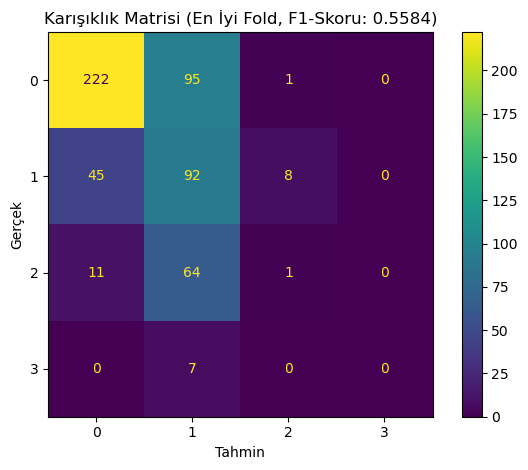

<Figure size 1000x700 with 0 Axes>

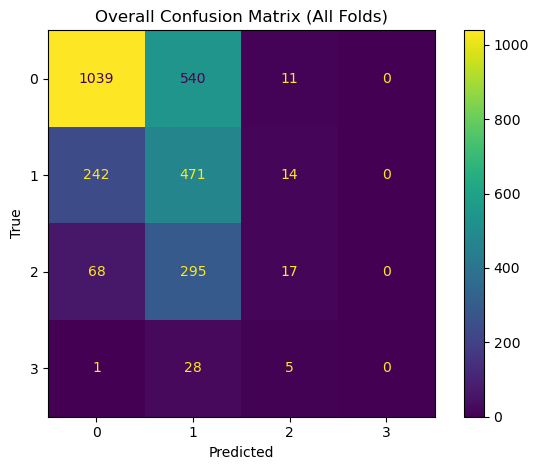

Fold Results: [0.5347562857617703, 0.555448656653476, 0.5425492947534525, 0.5583704114742398, 0.5290204942308502]
Best Fold Score: 0.5583704114742398


In [29]:
trainer = TrainML(n_splits=5, random_state=seed)

target_cols = [item for item in target_columns if item not in ['sii', 'PCIAT-Season']]
main_target = 'recalc_sii'

trainer.cross_validate(train_df, target_cols, main_target)
trainer.plot_confusion_matrix()
trainer.plot_overall_confusion_matrix()

print("Fold Results:", trainer.fold_results)
print("Best Fold Score:", trainer.best_fold_score)